In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p ~/ .kaggle

In [3]:
!cp -r /content/drive/MyDrive/kaggle.json ~/ .kaggle/


In [4]:
!chmod 600 ~/ .kaggle/kaggle.json


In [5]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 99% 60.0M/60.3M [00:03<00:00, 22.9MB/s]
100% 60.3M/60.3M [00:03<00:00, 16.7MB/s]


In [ ]:
!unzip /content/fer2013.zip

In [7]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy
import matplotlib.pyplot as plt

In [9]:
{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

seed=24
batch_size=  32

img_data_gen_args = dict(
                      rescale = 1/255.,
                         #rotation_range=90,
                      #width_shift_range=0.3,
                      #height_shift_range=0.3,
                      #shear_range=0.5,
                      #zoom_range=0.3,
                      #horizontal_flip=True,
                      #vertical_flip=True,
                      #fill_mode='reflect'
                         )

# Define the original class to new class mapping (positive, negative, and neutral)
class_mapping = {
    0: 1,  # Angry -> Negative
    1: 1,  # Disgust -> Negative
    2: 1,  # Fear -> Negative
    3: 0,  # Happy -> Positive
    4: 2,  # neutral -> neutral
    5: 1,  # sad -> negative
    6: 0   # surprise -> positive
}



In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.preprocessing import image_dataset_from_directory


class CustomDirectoryIterator(DirectoryIterator):
    def __getitem__(self, index):
        batch_x, batch_y = super().__getitem__(index)
        new_batch_y = np.zeros((batch_y.shape[0], 3))  # 3 classes: Positive, Negative, Neutral
        for i, y in enumerate(batch_y):
            original_class = np.argmax(y)
            new_class = class_mapping[original_class]
            new_batch_y[i, new_class] = 1
        return batch_x, new_batch_y

In [12]:
# Create an ImageDataGenerator
image_data_generator = ImageDataGenerator(**img_data_gen_args)

# Create a CustomDirectoryIterator for the training images
train_image_generator = CustomDirectoryIterator(
    directory="/content/train",
    image_data_generator=image_data_generator,
    target_size=(224, 224),  # Adjust to the target size (224, 224) is common for transfer learning models like VGG, ResNet, etc.
    batch_size=batch_size,
    interpolation="lanczos",
    color_mode="rgb",  # "rgb" for color images, "grayscale" for black and white images
    class_mode="categorical"  # "categorical" for multi-class classification
)

Found 28709 images belonging to 7 classes.


In [13]:
# Create a CustomDirectoryIterator for the test images
test_image_generator = CustomDirectoryIterator(
    directory="/content/test",
    image_data_generator=image_data_generator,
    target_size=(224, 224),  # Adjust to the target size (224, 224) is common for transfer learning models like VGG, ResNet, etc.
    batch_size=batch_size,
    interpolation="lanczos",
    color_mode="rgb",  # "rgb" for color images, "grayscale" for black and white images
    class_mode="categorical"  # "categorical" for multi-class classification
)

Found 7178 images belonging to 7 classes.


# Sanity check

In [14]:
class_names = ["Positive", "Negative", "Neutral"]

def plot_images_with_labels(images, labels, class_names):
    num_images=9
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label_index = labels[i].argmax()
        plt.title(class_names[label_index])
        plt.axis('off')
    plt.show()

In [15]:
x_train,y_train = train_image_generator.__getitem__(3)
y_train.shape

(32, 3)

In [16]:
x_test,y_test = test_image_generator.__getitem__(3)
y_test.shape

(32, 3)

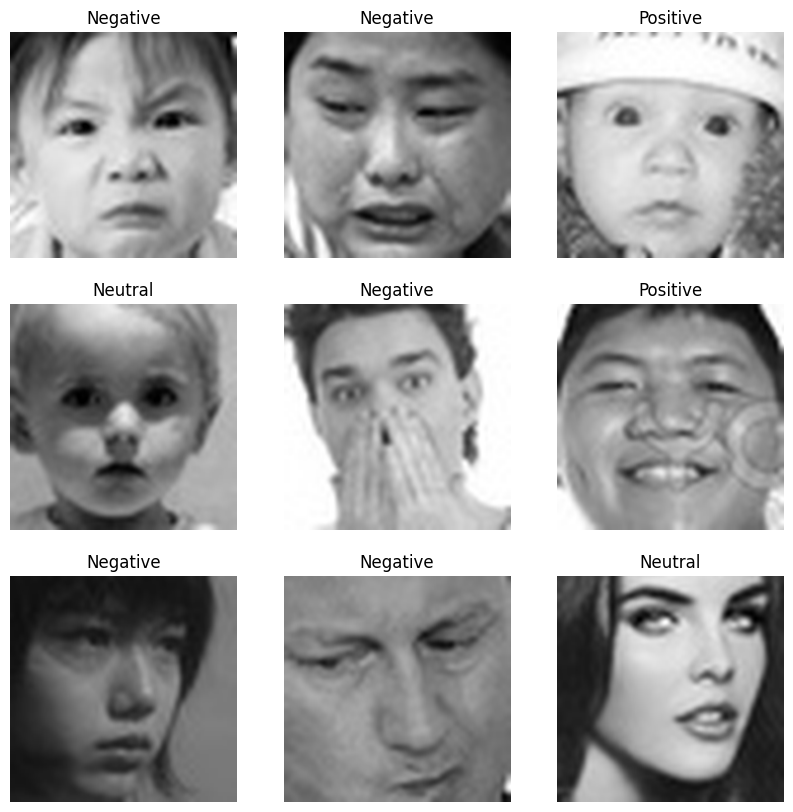

In [17]:
# Plot a 3x3 grid of images with labels
plot_images_with_labels(x_train, y_train, class_names)

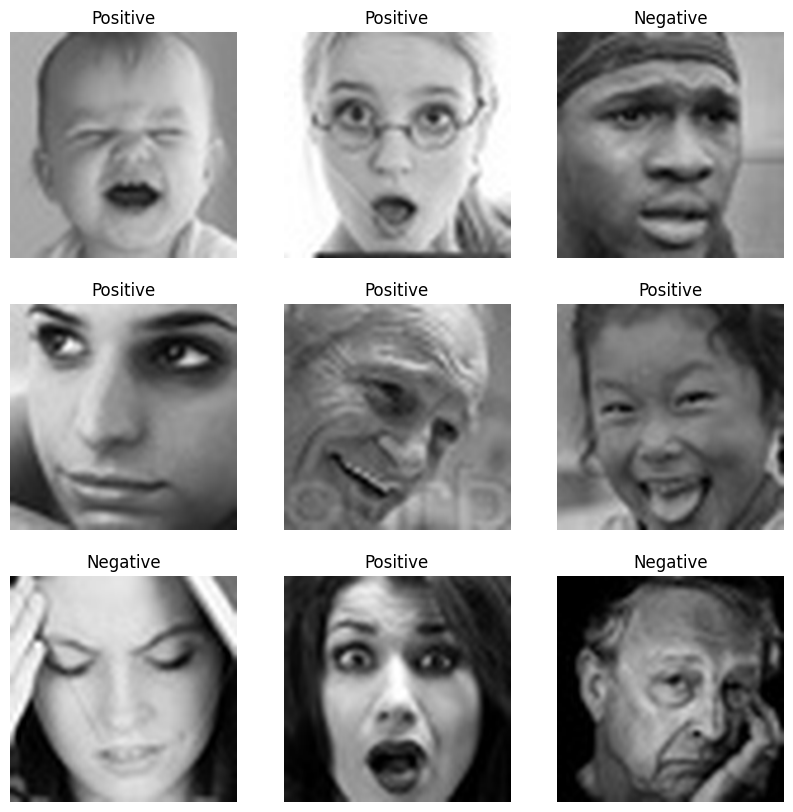

In [18]:
plot_images_with_labels(x_test, y_test, class_names)

# Transfer Learning for classification

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
model = tf.keras.applications.MobileNetV2()
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
base_input = model.layers[0].input

In [ ]:
base_output = model.layers[-2].output

In [ ]:
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d_1')>

In [ ]:
Emotion_output = layers.Dense(128, activation = 'relu')(base_output)
Emotion_output = layers.Dense(64, activation = 'relu')(Emotion_output)
Emotion_output = layers.Dense(7, activation = "softmax")(Emotion_output)

In [ ]:
final_model = tf.keras.Model(inputs = base_input, outputs = Emotion_output)
final_model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [ ]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
## let's introduce the Modelcheckpoint to save the best model for each epoch to avoid errors
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
## let's implement the EarlyStopping!
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'), checkpointer ]

In [ ]:
history = final_model.fit(train_image_generator,validation_data=test_image_generator,
                    epochs=100, verbose= 1, callbacks=callbacks)


Epoch 1/100
  3/898 [..............................] - ETA: 1:08 - loss: 2.0973 - accuracy: 0.1875

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()